In [1]:
import os
import pickle
import numpy as np
from tqdm.notebook import tqdm
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add

### Generating features

In [2]:
# load vgg16 model
cnn_model = InceptionV3()
# restructure the model
cnn_model = Model(inputs=cnn_model.inputs, outputs=cnn_model.layers[-2].output)
# summarize
print(cnn_model.summary())

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 299, 299,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 149, 149,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 149, 149,  │         96 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 149, 149,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 147, 147,  │      9,216 │ activation[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 147, 147,  │         96 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 147, 147,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 147, 147,  │     18,432 │ activation_1[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 147, 147,  │        192 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 147, 147,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 73, 73,    │          0 │ activation_2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 73, 73,    │      5,120 │ max_pooling2d[0]… │
│                     │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 73, 73,    │        240 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 73, 73,    │          0 │ batch_normalizat… │
│ (Activation)        │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 71, 71,    │    138,240 │ activation_3[0][… │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 71, 71,    │        576 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 71, 71,    │          0 │ batch_normalizat

 Total params: 21,802,784 (83.17 MB)

 Trainable params: 21,768,352 (83.04 MB)

 Non-trainable params: 34,432 (134.50 KB)

None


In [3]:
# Function to preprocess an image
def img_features(img_path):
    img = load_img(img_path, target_size=(299, 299))
    img = img_to_array(img)
    # img = img.reshape((1, img.shape[0], img.shape[1], img.shape[2]))
    img = np.expand_dims(img, axis=0)
    img = preprocess_input(img)
    return cnn_model.predict(img)

In [4]:
features = {}
for img_name in tqdm(os.listdir('./Images/')):
    features[img_name] = img_features(f"./Images/{img_name}")

  0%|          | 0/8091 [00:00<?, ?it/s]

e:\Learning\Deep Learning\Image Captioning\imgcap\Lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor']. Received: the structure of inputs=*
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

In [6]:
pickle.dump(features, open(os.path.join('./', 'features.pkl'), 'wb'))

In [2]:
# load features from pickle
with open(os.path.join('./', 'features.pkl'), 'rb') as f:
    features = pickle.load(f)

### Reading Captions

In [3]:
with open(os.path.join('./', 'captions.txt'), 'r') as f:
    next(f)
    captions_doc = f.read()

In [4]:
# create mapping of image to captions
mapping = {}
# process lines
for line in tqdm(captions_doc.split('\n')):
    # split the line by comma(,)
    tokens = line.split(',')
    if len(line) < 2:
        continue
    image_id, caption = tokens[0], tokens[1:]
    # remove extension from image ID
    image_id = image_id.split('.')[0]
    # convert caption list to string
    caption = " ".join(caption)
    # create list if needed
    if image_id not in mapping:
        mapping[image_id] = []
    # store the caption
    mapping[image_id].append(caption)

  0%|          | 0/40456 [00:00<?, ?it/s]

In [5]:
def clean(cap_mapping):
    for img in cap_mapping.keys():
        preprocessed_caps = []
        for cap in cap_mapping[img]:
            cap = cap.lower()
            cap = cap.replace('[^A-Za-z]', '')
            cap = cap.replace(r'\s+', '')
            cap = 'startseq ' + " ".join([word for word in cap.split() if len(word)>1]) + ' endseq'
            preprocessed_caps.append(cap)
        cap_mapping[img] = preprocessed_caps
    return cap_mapping

In [6]:
clean_mapping = clean(mapping)

In [7]:
all_captions = []
for key in mapping:
    for caption in mapping[key]:
        all_captions.append(caption)

In [8]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1

In [9]:
vocab_size

8485

In [10]:
max_length = max([len(cap.split()) for cap in all_captions])
max_length

35

In [11]:
image_ids = list(mapping.keys())
split = int(len(image_ids) * 0.90)
train = image_ids[:split]
test = image_ids[split:]

In [12]:
# create data generator to get data in batch (avoids session crash)
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    # loop over images
    X1, X2, y = list(), list(), list()
    n = 0
    while 1:
        for key in data_keys:
            n += 1
            captions = mapping[key]
            # process each caption
            for caption in captions:
                # encode the sequence
                seq = tokenizer.texts_to_sequences([caption])[0]
                # split the sequence into X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pairs
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length, padding='post')[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    # store the sequences
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
            if n == batch_size:
                X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                yield {"image": X1, "text": X2}, y
                X1, X2, y = list(), list(), list()
                n = 0

### Model Creation

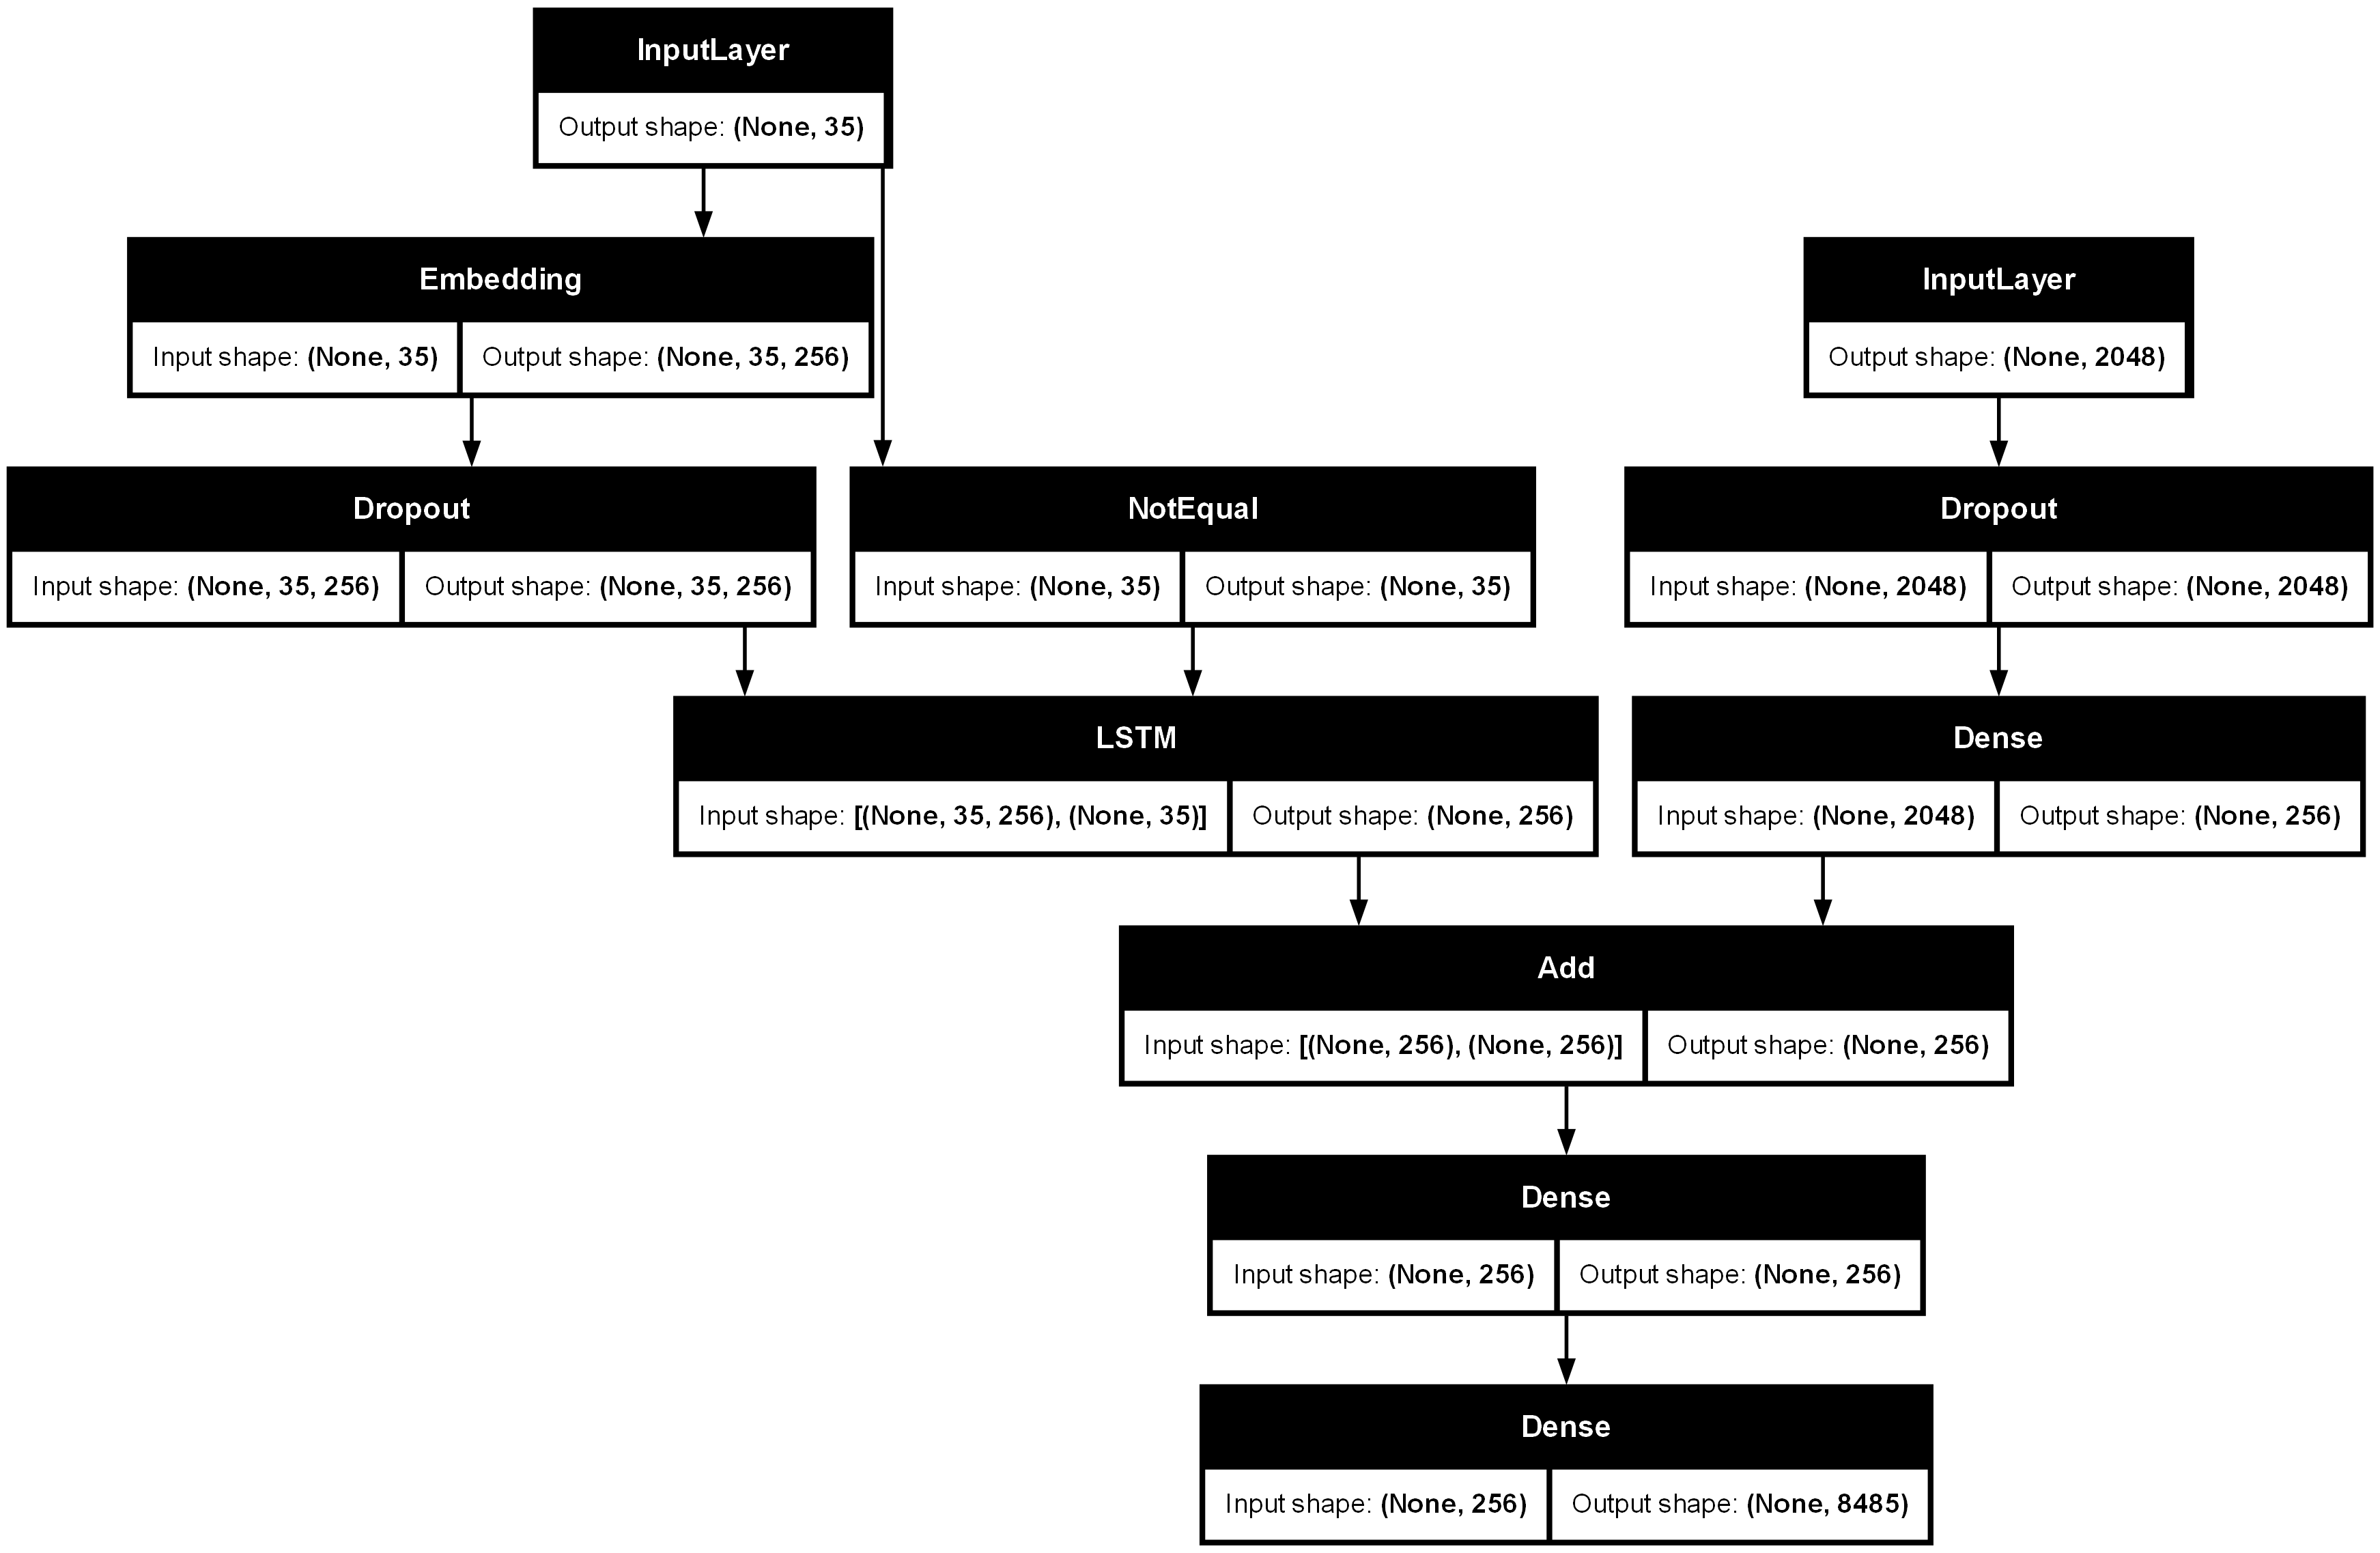

In [13]:
input1 = Input(shape=(2048,), name='Image')
fe1 = Dropout(0.25)(input1)
fe2 = Dense(256, activation='relu')(fe1)

input2 = Input(shape=(max_length,), name='text')
se1 = Embedding(vocab_size, 256, mask_zero=True)(input2)
se2 = Dropout(0.25)(se1)
se3 = LSTM(256)(se2)

decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[input1, input2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')

plot_model(model, show_shapes=True)